In [43]:
### Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_ubyte, feature

Setup

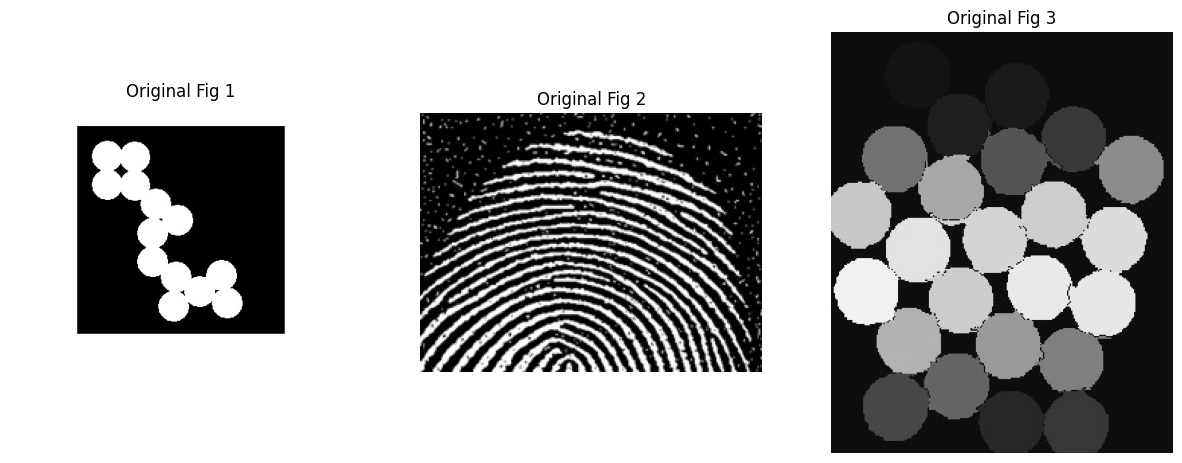

In [49]:
# Function to display images
def display_images(images, titles, rows=1, cols=3):
    """Display multiple images in a grid layout."""
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

base_path = r'C:\Users\danis\OneDrive\Documents\Repos\CV_PE2\Practicals\P3_\data'

# Load images for the tasks
fig1 = cv2.imread( rf"{base_path}\fig1.jpg", 0)  # Replace with the path to Fig 1
fig2 = cv2.imread( rf"{base_path}\fig2.jpg", 0)  # Replace with the path to Fig 1
fig3 = cv2.imread( rf"{base_path}\fig3.jpg", 0)  # Replace with the path to Fig 1

# Display original images
display_images([fig1, fig2, fig3], ['Original Fig 1', 'Original Fig 2', 'Original Fig 3'])

Task 1: Erode and Count Balls

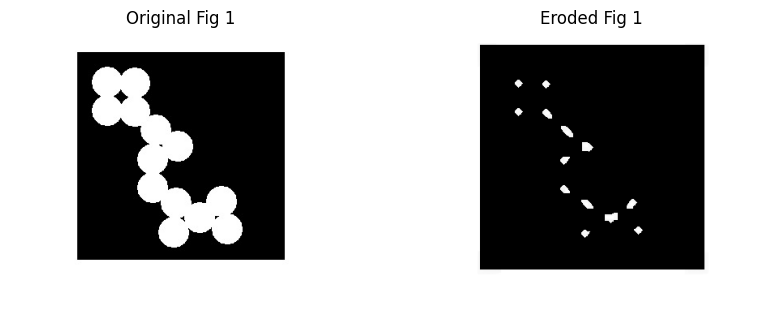

Total number of balls in Fig 1: 14


In [50]:

# Lab Task 1: Perform Erosion to separate balls in Fig 1
def task1_erosion(image, kernel_size=8):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded = cv2.erode(image, kernel, iterations=3)
    return eroded


# Optional: Count objects in the eroded image (Lab Task 1 extension)
def count_objects(eroded_image):
    _, thresh = cv2.threshold(eroded_image, 127, 255, cv2.THRESH_BINARY)
    num_labels, _ = cv2.connectedComponents(thresh)
    return num_labels - 1  # Subtract 1 for the background



# Perform operations for Lab Tasks
eroded_fig1 = task1_erosion(fig1)

# Display results
display_images([fig1, eroded_fig1], ['Original Fig 1', 'Eroded Fig 1'])
# Count objects in Fig 1 after erosion
num_balls = count_objects(eroded_fig1)
print(f"Total number of balls in Fig 1: {num_balls}")



Task 2: Fingerprint

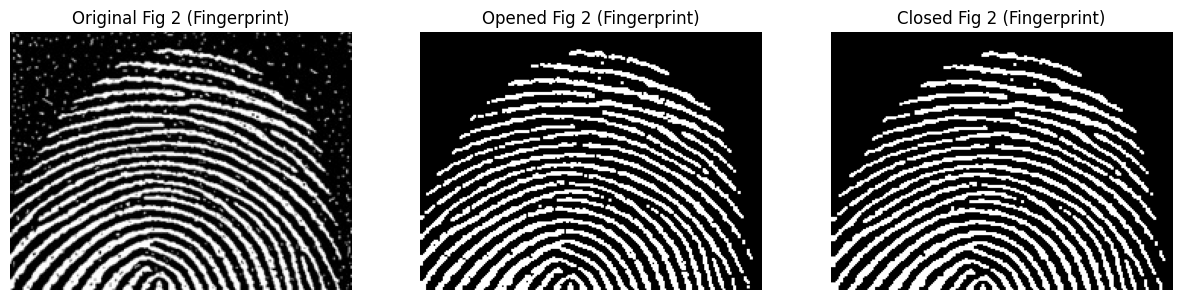

In [51]:
# Convert to binary image (if it's not already binary)
_, binary_fig2 = cv2.threshold(fig2, 127, 255, cv2.THRESH_BINARY)

# Define a 3x3 kernel for morphological operations
kernel = np.ones((2, 2), np.uint8)

# Apply Morphological Opening to remove noise (small points)
opened_fig2 = cv2.morphologyEx(binary_fig2, cv2.MORPH_OPEN, kernel)

# Apply Morphological Closing to fill gaps between ridges (or thumb impressions)
closed_fig2 = cv2.morphologyEx(opened_fig2, cv2.MORPH_CLOSE, kernel)


# Display the images: Original, Opened, and Closed
display_images([fig2, opened_fig2, closed_fig2], ['Original Fig 2 (Fingerprint)', 'Opened Fig 2 (Fingerprint)', 'Closed Fig 2 (Fingerprint)'])

Morphological Gradient

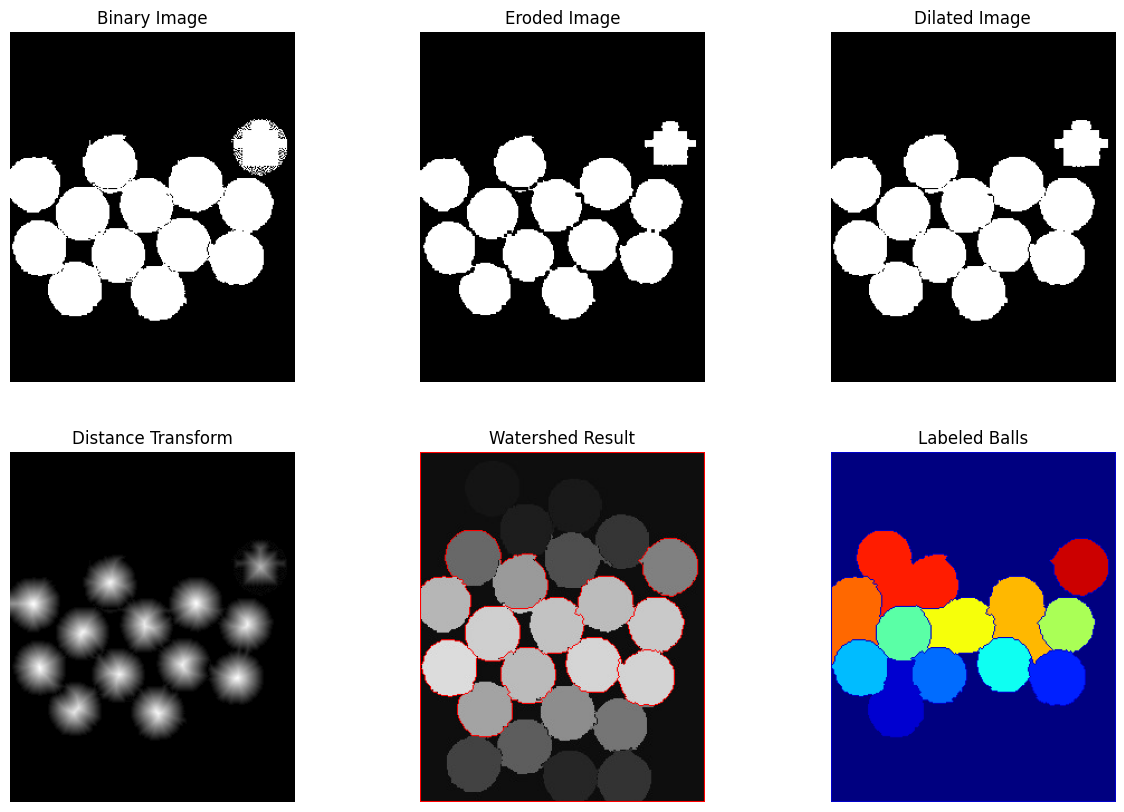

Number of balls detected: 13


In [58]:
# Step 1: Thresholding to binary image
_, binary_fig3 = cv2.threshold(fig3, 127, 255, cv2.THRESH_BINARY)

# Step 2: Apply erosion to separate balls that are too close
kernel = np.ones((3, 3), np.uint8)
eroded_fig3 = cv2.erode(binary_fig3, kernel, iterations=1)

# Step 3: Apply dilation to restore the size of the balls
dilated_fig3 = cv2.dilate(eroded_fig3, kernel, iterations=1)

# Step 4: Distance Transform to help separate close balls
dist_transform = cv2.distanceTransform(binary_fig3, cv2.DIST_L2, 5)
_, dist_transform_thresh = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Step 5: Apply watershed algorithm to separate connected objects
# Find sure background area
sure_bg = cv2.dilate(binary_fig3, kernel, iterations=3)

# Find sure foreground area using the distance transform
sure_fg = np.uint8(dist_transform_thresh)

# Subtract sure foreground from sure background to get the unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

# Label markers for the watershed algorithm
_, markers = cv2.connectedComponents(sure_fg)

# Mark the unknown region as 0
markers[unknown == 255] = 0

# Convert the grayscale image to BGR format for the watershed algorithm
fig3_bgr = cv2.cvtColor(fig3, cv2.COLOR_GRAY2BGR)

# Apply watershed algorithm
try:
    markers = cv2.watershed(fig3_bgr, markers)
except cv2.error as e:
    raise ValueError(f"Watershed algorithm failed: {e}")

# Mark boundaries with red on the original image
fig3_bgr[markers == -1] = [255, 0, 0]

# Step 6: Count the number of distinct balls
# Exclude background marker (label 0)
unique_markers = np.unique(markers)
num_balls = len(unique_markers) - 1  # Subtract 1 to exclude the background

# Step 7: Visualize the output
# Create a color map for labeled balls
colored_markers = np.uint8(markers * (255 / num_balls))
output_image = cv2.applyColorMap(colored_markers, cv2.COLORMAP_JET)

# Display all images
def display_images(images, titles):
    plt.figure(figsize=(15, 10))
    num_images = len(images)
    rows = (num_images // 3) + (num_images % 3 != 0)  # Dynamic rows calculation
    cols = 3  # 3 columns per row
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray' if len(images[i].shape) == 2 else None)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Display images
display_images(
    [binary_fig3, eroded_fig3, dilated_fig3, dist_transform, fig3_bgr, output_image],
    [
        'Binary Image', 'Eroded Image', 'Dilated Image', 
        'Distance Transform', 'Watershed Result', 'Labeled Balls'
    ]
)

# Print the number of balls detected
print(f"Number of balls detected: {num_balls}")
